# XGBoost

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model as lm
from sklearn import model_selection as ms
sklearn.set_config(print_changed_only=False)

import xgboost as xgb

import copy

import import_ipynb

from _Self_Written_Functions_Sheet import (conditions_edit, nbrhd_rank, drop_nbrhd,
totallivsf_add, drop_grlivarea, bsmtfin_add, drop_bsmtfinsf12, totalporchsf_add,
drop_porches, yrsremodtosold_add, drop_yrsoldremod, fireplace_yes, drop_fireplaces,
pool_yes, drop_poolarea, totalbaths_add, drop_baths, totalbsmtbaths_add,
drop_bsmtbaths)

from _Self_Written_Functions_Sheet import (dum_scale, use_og_data, comb_list_generator,
                                           apply_comb_list, rmse)

importing Jupyter notebook from _Self_Written_Functions_Sheet.ipynb


In [2]:
hp_train = pd.read_csv('..\hp_2a_ranked_edited_train.csv', index_col=0)
hp_test = pd.read_csv('..\hp_2a_ranked_edited_test.csv', index_col=0)
hp_logsp = pd.read_csv('..\hp_1a_no_imputation_logsaleprice.csv', index_col=0)
hp_saleprice = pd.read_csv('..\hp_1a_no_imputation_saleprice.csv', index_col=0)

# saving train index
hp_index = hp_train.index

combo_nonedit = pd.concat([hp_train, hp_test])
combo_nonedit.columns = hp_train.columns

# convert all possible numeric types to numeric
for col in combo_nonedit.columns: 
    combo_nonedit[col] = combo_nonedit[col].astype('float', errors='ignore')

combo_cols = list(combo_nonedit.columns)

combo = copy.deepcopy(combo_nonedit)

combo

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,2-STORY 1946 & NEWER,RL,65.0,8450.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,4.0,3.0,PConc,4.0,3.0,1.0,6.0,706.0,1.0,0.0,150.0,856.0,GasA,5.0,1.0,5.0,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,8.0,7.0,0.0,None,Attchd,2003.0,2.0,2.0,548.0,3.0,3.0,3.0,0.0,61.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Feb,2008.0,WD,Normal
1,1-STORY 1946 & NEWER ALL STYLES,RL,80.0,9600.0,1.0,0.0,Reg,Lvl,3.0,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,None,0.0,3.0,3.0,CBlock,4.0,3.0,4.0,5.0,978.0,1.0,0.0,284.0,1262.0,GasA,5.0,1.0,5.0,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,3.0,6.0,7.0,1.0,TA,Attchd,1976.0,2.0,2.0,460.0,3.0,3.0,3.0,298.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,May,2007.0,WD,Normal
2,2-STORY 1946 & NEWER,RL,68.0,11250.0,1.0,0.0,IR1,Lvl,3.0,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,4.0,3.0,PConc,4.0,3.0,2.0,6.0,486.0,1.0,0.0,434.0,920.0,GasA,5.0,1.0,5.0,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,4.0,6.0,7.0,1.0,TA,Attchd,2001.0,2.0,2.0,608.0,3.0,3.0,3.0,0.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Sep,2008.0,WD,Normal
3,2-STORY 1945 & OLDER,RL,60.0,9550.0,1.0,0.0,IR1,Lvl,3.0,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,WdShing,None,0.0,3.0,3.0,BrkTil,3.0,4.0,1.0,5.0,216.0,1.0,0.0,540.0,756.0,GasA,4.0,1.0,5.0,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,4.0,7.0,7.0,1.0,Gd,Detchd,1998.0,1.0,3.0,642.0,3.0,3.0,3.0,0.0,35.0,272.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Feb,2006.0,WD,Abnorml
4,2-STORY 1946 & NEWER,RL,84.0,14260.0,1.0,0.0,IR1,Lvl,3.0,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,4.0,3.0,PConc,4.0,3.0,3.0,6.0,655.0,1.0,0.0,490.0,1145.0,GasA,5.0,1.0,5.0,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,4.0,9.0,7.0,1.0,TA,Attchd,2000.0,2.0,3.0,836.0,3.0,3.0,3.0,192.0,84.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Dec,2008.0,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,2-STORY PUD - 1946 & NEWER,RM,21.0,1936.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsI,2Story,4.0,7.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,1.0,0.0,1.0,0.0,546.0,546.0,GasA,4.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,5.0,7.0,0.0,None,None,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,0.0,Jun,2006.0,WD,Normal
2913,2-STORY PUD - 1946 & NEWER,RM,21.0,1894.0,1.0,0.0,Reg,Lvl,3.0,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.0,5.0,1970.0,1970.0,Gable,CompShg,CemntBd,CemntBd,None,0.0,3.0,3.0,CBlock,3.0,3.0,1.0,3.0,252.0,1.0,0.0,294.0,546.0,GasA,3.0,1.0,5.0,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,3.0,6.0,7.0,0.0,None,CarPort,1970.0,1.0,1.0,286.0,3.0,3.0,3.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.

In [39]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
xgb_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results above
xgb_feat_eng = [nbrhd_rank, totallivsf_add, totalporchsf_add, fireplace_yes, drop_yrsoldremod,
                drop_fireplaces, drop_poolarea, drop_bsmtbaths]

for feat in xgb_feat_eng:
    feat(xgb_df)

# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(xgb_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

hp_full_strd_to_use

,Fireplace,TotalPorchSF,TotalLivSF,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscVal,NbMedianRank,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-1/2 STORY PUD - ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.050539,0.237373,0.150685,0.033420,1.0,0.0,1.0,0.666667,0.500,0.949275,0.122500,0.666667,0.50,0.8,0.75,0.25,1.000000,0.176060,0.166667,

In [7]:
state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_full_strd_to_use,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

# using GPU
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=state,
                           eval_metric='rmse', tree_method='gpu_hist',
                           sampling_method='gradient_based')

In [5]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# setting parameters
learningrate = [0.1, 0.3, 0.5, 1]
gamm = [0, 0.1, 1]
# maxdepth = [2, 4, 6]
sub_sample = [0.1, 0.25, 0.5, 1]
lambd = [0.1, 0.25, 0.5, 0.75, 1]
alph = [0.1, 0.25, 0.5, 0.75, 1]

gparam_xgb = {'eta': learningrate,
              'gamma': gamm,
#               'max_depth': maxdepth,
              'subsample': sub_sample,
              'lambda': lambd,
              'alpha': alph}

# setting parameters
gs_xgb = ms.GridSearchCV(xgb_reg, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1,
                         scoring='neg_root_mean_squared_error', return_train_score=True, verbose=4)

%time gs_xgb.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_xgb.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_xgb.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb, ytrain, xtrain))
test_rmse.append(rmse(gs_xgb, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_xgb.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_res_df = pd.DataFrame(xgb_list_results).T
xgb_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_res_df = pd.concat([xgb_res_df, best_par_df], axis=1, sort=False)

xgb_res_df

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
Wall time: 40min 8s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,alpha,eta,gamma,lambda,subsample
0,0.967466,0.924558,0.071492,0.113073,-0.041581,0.5,0.1,0,0.5,0.25


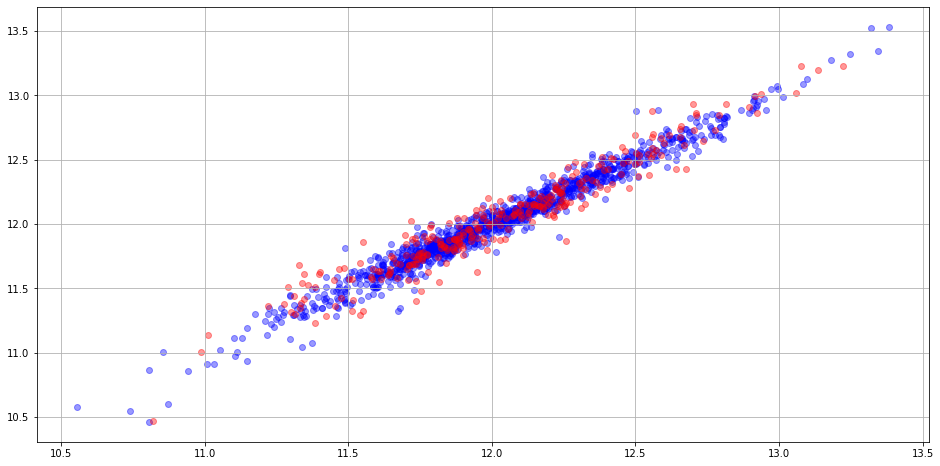

In [6]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_xgb.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_xgb.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [8]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# using GPU
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=state,
                           eval_metric='rmse', verbosity=3, tree_method='gpu_hist',
                           sampling_method='gradient_based')

# setting parameters
learningrate = [0.05, 0.1, 0.15, 0.2, 0.25]
gamm = [0, 0.001, 0.01]
# maxdepth = [2, 4, 6]
sub_sample = [0.15, 0.2, 0.25, 0.3, 0.35]
lambd = [0.3, 0.4, 0.5, 0.6, 0.7]
alph = [0.3, 0.4, 0.5, 0.6, 0.7]

gparam_xgb = {'eta': learningrate,
              'gamma': gamm,
#               'max_depth': maxdepth,
              'subsample': sub_sample,
              'lambda': lambd,
              'alpha': alph}

# setting parameters
gs_xgb = ms.GridSearchCV(xgb_reg, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1,
                         scoring='neg_root_mean_squared_error', return_train_score=True, verbose=4)

%time gs_xgb.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_xgb.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_xgb.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb, ytrain, xtrain))
test_rmse.append(rmse(gs_xgb, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_xgb.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_res_df = pd.DataFrame(xgb_list_results).T
xgb_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_res_df = pd.concat([xgb_res_df, best_par_df], axis=1, sort=False)

xgb_res_df

Fitting 5 folds for each of 1875 candidates, totalling 9375 fits
[13:06:17] DEBUG: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/tree/updater_gpu_hist.cu:873: [GPU Hist]: Configure
[13:06:17] ======== Monitor (0): SketchContainer ========
[13:06:17] MakeCuts: 0.000762s, 1 calls @ 762us

[13:06:17] Prune: 0.000458s, 1 calls @ 458us

[13:06:17] ScanInput: 0.000282s, 1 calls @ 282us

[13:06:17] Unique: 0.000306s, 1 calls @ 306us

[13:06:17] ======== Monitor (0): Learner ========
[13:06:17] Configure: 0s, 1 calls @ 0us

[13:06:17] EvalOneIter: 0.00033s, 100 calls @ 330us

[13:06:17] GetGradient: 0.006454s, 100 calls @ 6454us

[13:06:17] PredictRaw: 0.000333s, 100 calls @ 333us

[13:06:17] UpdateOneIter: 0.404652s, 100 calls @ 404652us

[13:06:17] ======== Monitor (0): GBTree ========
[13:06:17] BoostNewTrees: 0.405256s, 100 calls @ 405256us

[13:06:17] CommitModel: 2.1e-05s, 100 calls @ 21us

[13:06:17] ======== Device 0 Memory Allocations:  ========
[13:06:17] Peak memo

,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,alpha,eta,gamma,lambda,subsample
0,0.971526,0.92027,0.066882,0.116242,-0.04936,0.5,0.1,0.001,0.7,0.3


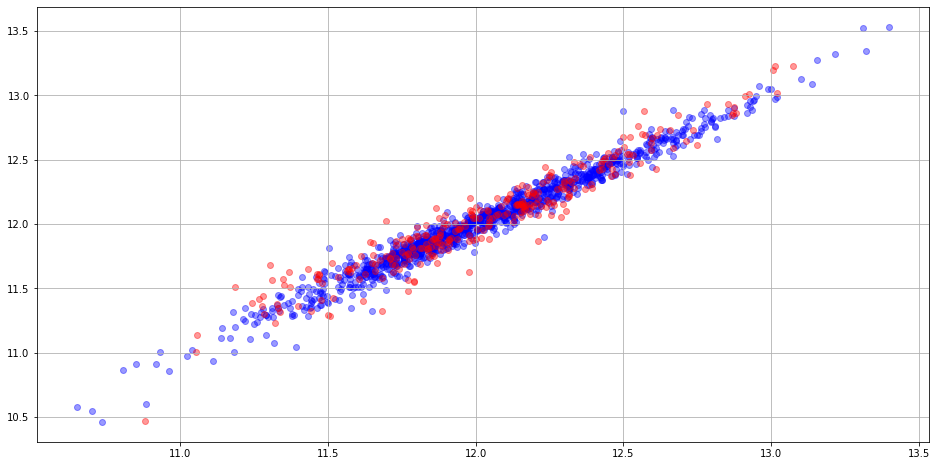

In [9]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_xgb.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_xgb.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [10]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# using GPU
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=state,
                           eval_metric='rmse', verbosity=2, tree_method='gpu_hist',
                           sampling_method='gradient_based')

# setting parameters
learningrate = [0.06, 0.08, 0.1, 0.12, 0.14]
gamm = [0.0005, 0.001, 0.005]
# maxdepth = [2, 4, 6]
sub_sample = [0.26, 0.28, 0.3, 0.32, 0.34]
lambd = [0.5, 0.6, 0.7, 0.8, 0.9]
alph = [0.41, 0.45, 0.5, 0.55, 0.59]

gparam_xgb = {'eta': learningrate,
              'gamma': gamm,
#               'max_depth': maxdepth,
              'subsample': sub_sample,
              'lambda': lambd,
              'alpha': alph}

# setting parameters
gs_xgb = ms.GridSearchCV(xgb_reg, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1,
                         scoring='neg_root_mean_squared_error', return_train_score=True, verbose=4)

%time gs_xgb.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_xgb.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_xgb.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb, ytrain, xtrain))
test_rmse.append(rmse(gs_xgb, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_xgb.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_res_df = pd.DataFrame(xgb_list_results).T
xgb_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_res_df = pd.concat([xgb_res_df, best_par_df], axis=1, sort=False)

xgb_res_df

[13:11:14] ======== Monitor (0): Learner ========
[13:11:14] Configure: 0.00042s, 1 calls @ 420us

[13:11:14] ======== Monitor (0): GBTree ========
[13:11:14] ======== Device 0 Memory Allocations:  ========
[13:11:14] Peak memory usage: 6MiB
[13:11:14] Number of allocations: 7759
[13:11:14] ======== Monitor (0): updater_gpu_hist ========
Fitting 5 folds for each of 1875 candidates, totalling 9375 fits
Wall time: 1h 21min 25s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,alpha,eta,gamma,lambda,subsample
0,0.971526,0.92027,0.066882,0.116242,-0.04936,0.5,0.1,0.001,0.7,0.3


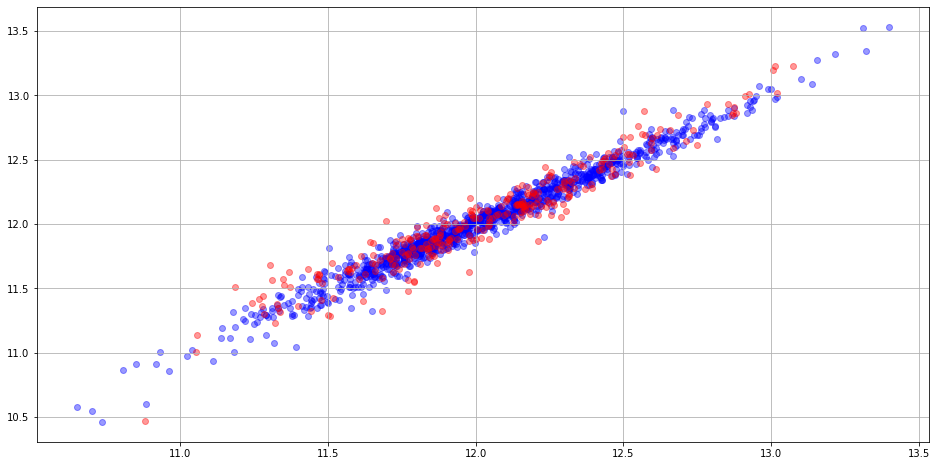

In [11]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_xgb.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_xgb.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [12]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# using GPU
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=state,
                           eval_metric='rmse', verbosity=2, tree_method='gpu_hist',
                           sampling_method='gradient_based')

# setting parameters
learningrate = [0.09, 0.1, 0.11]
gamm = [0.0006, 0.0008, 0.001, 0.0012]
# maxdepth = [2, 4, 6]
sub_sample = [0.29, 0.3, 0.31]
lambd = [0.61, 0.65, 0.7, 0.75, 0.79]
alph = [0.46, 0.48, 0.5, 0.52, 0.54]

gparam_xgb = {'eta': learningrate,
              'gamma': gamm,
#               'max_depth': maxdepth,
              'subsample': sub_sample,
              'lambda': lambd,
              'alpha': alph}

# setting parameters
gs_xgb = ms.GridSearchCV(xgb_reg, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1,
                         scoring='neg_root_mean_squared_error', return_train_score=True, verbose=4)

%time gs_xgb.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_xgb.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_xgb.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb, ytrain, xtrain))
test_rmse.append(rmse(gs_xgb, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_xgb.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_res_df = pd.DataFrame(xgb_list_results).T
xgb_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_res_df = pd.concat([xgb_res_df, best_par_df], axis=1, sort=False)

xgb_res_df

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Wall time: 39min 45s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,alpha,eta,gamma,lambda,subsample
0,0.970655,0.919651,0.067897,0.116692,-0.048795,0.46,0.1,0.0006,0.75,0.29


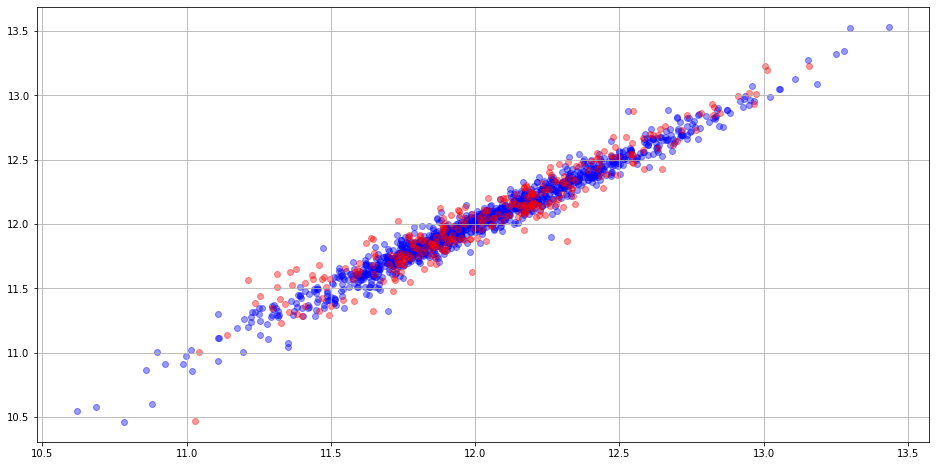

In [13]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_xgb.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_xgb.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [16]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# using GPU
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=state,
                           eval_metric='rmse', verbosity=2, tree_method='gpu_hist',
                           sampling_method='gradient_based')

# setting parameters
learningrate = [0.095, 0.1, 0.105]
gamm = [0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
# maxdepth = [2, 4, 6]
sub_sample = [0.27, 0.28, 0.29, 0.3, 0.31]
lambd = [0.73, 0.74, 0.75, 0.76, 0.77]
alph = [0.44, 0.45, 0.46, 0.47, 0.48]

gparam_xgb = {'eta': learningrate,
              'gamma': gamm,
#               'max_depth': maxdepth,
              'subsample': sub_sample,
              'lambda': lambd,
              'alpha': alph}

# setting parameters
gs_xgb = ms.GridSearchCV(xgb_reg, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1,
                         scoring='neg_root_mean_squared_error', return_train_score=True, verbose=4)

%time gs_xgb.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_xgb.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_xgb.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb, ytrain, xtrain))
test_rmse.append(rmse(gs_xgb, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_xgb.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_res_df = pd.DataFrame(xgb_list_results).T
xgb_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_res_df = pd.concat([xgb_res_df, best_par_df], axis=1, sort=False)

xgb_res_df

Fitting 5 folds for each of 1875 candidates, totalling 9375 fits
Wall time: 1h 22min 54s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,alpha,eta,gamma,lambda,subsample
0,0.970655,0.919651,0.067897,0.116692,-0.048795,0.46,0.1,0.0006,0.75,0.29


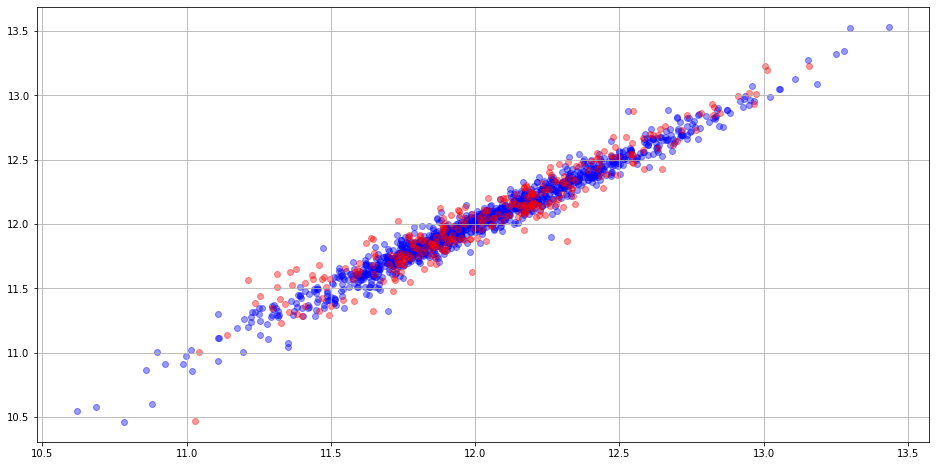

In [17]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_xgb.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_xgb.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

In [20]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# using GPU
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=state,
                           eval_metric='rmse', verbosity=2, tree_method='gpu_hist',
                           sampling_method='gradient_based')

# setting parameters
learningrate = [0.096, 0.098, 0.1, 0.102, 0.104]
gamm = [0.00056, 0.00058, 0.0006, 0.00062, 0.00064]
maxdepth = [4, 5, 6, 7, 8]
sub_sample = [0.29]
lambd = [0.75]
alph = [0.46]

gparam_xgb = {'eta': learningrate,
              'gamma': gamm,
              'max_depth': maxdepth,
              'subsample': sub_sample,
              'lambda': lambd,
              'alpha': alph}

# setting parameters
gs_xgb = ms.GridSearchCV(xgb_reg, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1,
                         scoring='neg_root_mean_squared_error', return_train_score=True, verbose=4)

%time gs_xgb.fit(xtrain, ytrain)

# setting up dataframe for results
train_scores.append(gs_xgb.best_estimator_.score(xtrain, ytrain))
test_scores.append(gs_xgb.best_estimator_.score(xtest, ytest))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb, ytrain, xtrain))
test_rmse.append(rmse(gs_xgb, ytest, xtest))

# add the best parameters to the df
best_par_list.append(gs_xgb.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_res_df = pd.DataFrame(xgb_list_results).T
xgb_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_res_df = pd.concat([xgb_res_df, best_par_df], axis=1, sort=False)

xgb_res_df


Fitting 5 folds for each of 125 candidates, totalling 625 fits
Wall time: 5min 41s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,alpha,eta,gamma,lambda,max_depth,subsample
0,0.970655,0.919651,0.067897,0.116692,-0.048795,0.46,0.1,0.0006,0.75,6,0.29


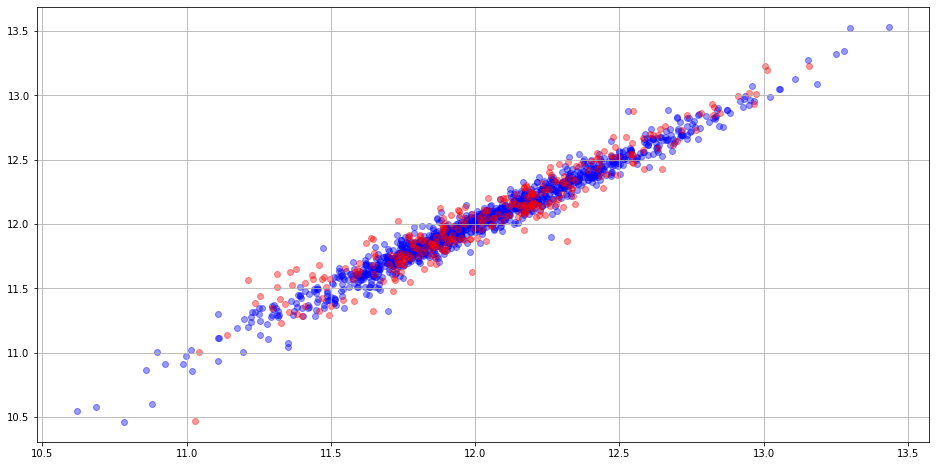

In [21]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_xgb.best_estimator_.predict(xtrain), ytrain, color='blue', alpha=0.4)
plt.scatter(gs_xgb.best_estimator_.predict(xtest), ytest, color='red', alpha=0.4)
plt.grid(which='both')

# Using reduced dataset

In [23]:
sorted_importance_xgb = sorted(zip(hp_full_strd_to_use.columns,
                                   gs_xgb.best_estimator_.feature_importances_),
                               key=lambda t:t[1], reverse=True)

filtered_sorted_importance_xgb = [x for x in sorted_importance_xgb if x[1]>0]

df_filter_sort_xgb = [x[0] for x in filtered_sorted_importance_xgb]

df_filter_sort_xgb

hp_fullstrd_filtrsrt = hp_full_strd_to_use[df_filter_sort_xgb]
hp_fullstrd_filtrsrt

,GarageQual,GarageCars,KitchenQual,ExterQual,BsmtQual,OverallQual,ExterCond,GrLivArea,Fence,Heating_Grav,MSZoning_RM,RoofStyle_Gambrel,Fireplace,MoSold_Dec,Street,TotalLivSF,GarageFinish,TotalBsmtSF,Condition1_RRAe,MoSold_Feb,OpenPorchSF,KitchenAbvGr,Functional,FireplaceQu_Po,Neighborhood_IDOTRR,OverallCond,GarageType_CarPort,Foundation_Wood,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,SaleType_WD,PavedDrive,SaleCondition_Family,GarageCond,SaleCondition_Alloca,GarageYrBlt,GarageType_Basment,LandSlope_Mod,Condition2_Norm,MiscFeature_Shed,BsmtCond,1stFlrSF,Exterior1st_CBlock,SaleType_New,Alley,Neighborhood_MeadowV,CentralAir,LotArea,Neighborhood_NridgHt,TotRmsAbvGrd,TotalPorchSF,SaleCondition_Normal,FullBath,YearBuilt,Neighborhood_Edwards,BedroomAbvGr,3SsnPorch,GarageArea,Exterior1st_BrkFace,LandContour_Lvl,MasVnrType_BrkFace,HeatingQC,NbMedianRank,HouseStyle_SFoyer,Neighborhood_Gilbert,WoodDeckSF,EnclosedPorch,Neighborhood_SWISU,MSSubClass_2-STORY 1945 & OLDER,GarageType_Detchd,Condition1_Norm,BsmtExposure,LotConfig_FR3,MiscVal,2ndFlrSF,LotConfig_FR2,LowQualFinSF,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,LandContour_Low,Neighborhood_BrkSide,MoSold_Jun,MSSubClass_1-STORY 1945 & OLDER,Foundation_CBlock,Neighborhood_NAmes,ScreenPorch,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSZoning_FV,BsmtFinSF2,MoSold_Aug,HouseStyle_2Story,MasVnrType_Stone,MoSold_May,PoolQC,BsmtFinType2,BsmtUnfSF,HouseStyle_1Story,Exterior1st_Wd Sdng,Electrical,FireplaceQu_Fa,RoofStyle_Gable,MoSold_Nov,FireplaceQu_Gd,MSSubClass_2-1/2 STORY ALL AGES,MoSold_Jul,Exterior2nd_HdBoard,GarageType_BuiltIn,BsmtFinSF1,FireplaceQu_TA,MasVnrArea,LotFrontage,HalfBath,BsmtFinType1,Neighborhood_NWAmes,MSSubClass_2-STORY 1946 & NEWER,Exterior1st_VinylSd,MoSold_Oct,Neighborhood_Somerst,MoSold_Mar,RoofStyle_Hip,LandContour_HLS,Exterior1st_WdShing,LotShape_Reg,MoSold_Jan,LotConfig_Inside,Exterior2nd_WdShing,Condition1_Feedr,MoSold_Sep,LotConfig_CulDSac,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,Foundation_PConc,Exterior1st_CemntBd,Exterior1st_MetalSd,Exterior1st_HdBoard,Exterior2nd_Plywood,Exterior2nd_Wd Sdng,Neighborhood_CollgCr,MSZoning_RH,LotShape_IR2,Exterior2nd_Stucco,Neighborhood_NoRidge,MSZoning_RL,Heating_GasA,GarageType_Attchd,Neighborhood_SawyerW,Exterior1st_Stucco,Neighborhood_Sawyer,Exterior2nd_CemntBd,Neighborhood_StoneBr,Condition2_PosN,Neighborhood_Veenker
0,0.6,0.4,0.666667,0.666667,0.8,0.666667,0.50,0.289015,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.237373,0.666667,0.168008,0.0,1.0,0.082210,0.333333,1.000000,0.0,0.0,0.500,0.0,0.0,0.0,1.0,1.0,0.0,0.6,0.0,0.996517,0.0,0.0,1.0,0.0,0.75,0.109641,0.0,0.0,0.0,0.0,1.0,0.033420,0.0,0.461538,0.050539,1.0,0.50,0.949275,0.0,0.375,0.0,0.368280,0.0,1.0,1.0,1.00,0.458333,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.25,0.0,0.000000,0.413559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.166667,0.064212,0.0,0.0,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.176060,0.0,0.122500,0.150685,0.5,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.6,0.4,0.333333,0.333333,0.8,0.555556,0.50,0.194917,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.217307,0.666667,0.247694,0.0,0.0,0.000000,0.333333,1.000000,0.0,0.0,0.875,0.0,0.0,0.0,1.0,1.0,0.0,0.6,0.0,0.983085,0.0,0.0,1.0,0.0,0.75,0.194917,0.0,0.0,0.0,0.0,1.0,0.038795,0.0,0.307692,0.000000,1.0,0.50,0.753623,0.0,0.375,0.0,0.309140,0.0,1.0,0.0,1.00,0.750000,0.0,0.0,0.209270,0.000000,0.0,0.0,0.0,0.0,1.00,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,0.166667,0.121575,1.0,0.0,1.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.243890,1.0,0.000000,0.202055,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.6,0.4,0.666667,0.666667,0.8,0.666667,0.50,0.304978,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.220955,0.666667,0.1

In [24]:
state = 0

# setting up train and test sets
xtrain_fs, xtest_fs, ytrain_fs, ytest_fs = ms.train_test_split(hp_fullstrd_filtrsrt,
                                                               hp_logsp,
                                                               test_size=0.2,
                                                               random_state=state)

# Must flatten to fit
ytrain_fs = ytrain_fs.values.flatten()

In [25]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# using GPU
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=state,
                           eval_metric='rmse', verbosity=2, tree_method='gpu_hist',
                           sampling_method='gradient_based')

# setting parameters
learningrate = [0.01, 0.1, 1]
gamm = [0.0001, 0.001, 0.01, 0.1]
# maxdepth = [2, 4, 6]
sub_sample = [0.25, 0.5, 0.75, 1]
lambd = [0.25, 0.5, 0.75, 1]
alph = [0.25, 0.5, 0.75, 1]

gparam_xgb_fs = {'eta': learningrate,
                 'gamma': gamm,
#               'max_depth': maxdepth,
                 'subsample': sub_sample,
                 'lambda': lambd,
                 'alpha': alph}

# setting parameters
gs_xgb_fs = ms.GridSearchCV(xgb_reg, gparam_xgb_fs, cv=n_folds, refit=True, n_jobs=-1,
                            scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_xgb_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_xgb_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_xgb_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_xgb_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_xgb_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_res_df = pd.DataFrame(xgb_list_results).T
xgb_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_res_df = pd.concat([xgb_res_df, best_par_df], axis=1, sort=False)

xgb_res_df

Wall time: 22min 58s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,alpha,eta,gamma,lambda,subsample
0,0.98053,0.930001,0.055305,0.108918,-0.053613,0.25,0.1,0.01,0.25,0.75


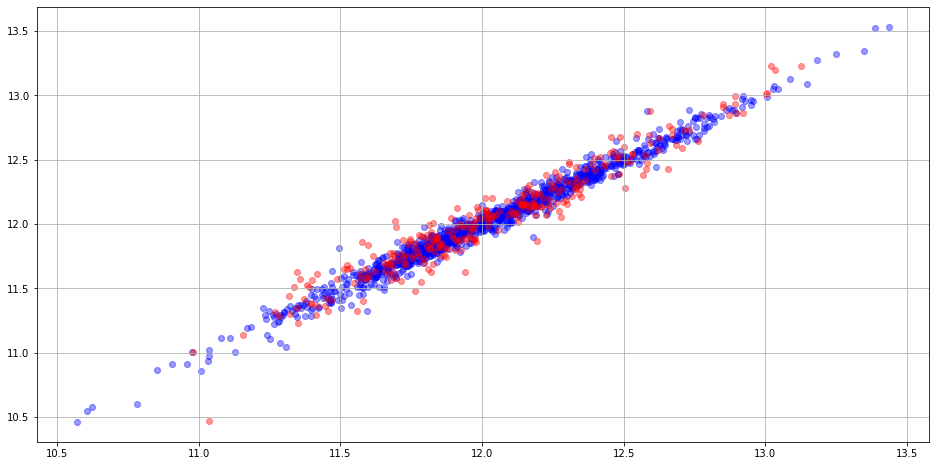

In [26]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_xgb_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_xgb_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

In [29]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# using GPU
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=state,
                           eval_metric='rmse', verbosity=2, tree_method='gpu_hist',
                           sampling_method='gradient_based')

# setting parameters
learningrate = [0.05, 0.1, 0.5]
gamm = [0.005, 0.01, 0.05]
# maxdepth = [2, 4, 6]
sub_sample = [0.7, 0.75, 0.8]
lambd = [0.1, 0.2, 0.25, 0.3, 0.4]
alph = [0.1, 0.2, 0.25, 0.3, 0.4]

gparam_xgb_fs = {'eta': learningrate,
                 'gamma': gamm,
#               'max_depth': maxdepth,
                 'subsample': sub_sample,
                 'lambda': lambd,
                 'alpha': alph}

# setting parameters
gs_xgb_fs = ms.GridSearchCV(xgb_reg, gparam_xgb_fs, cv=n_folds, refit=True, n_jobs=-1,
                            scoring='neg_root_mean_squared_error', return_train_score=True,
                            verbose=3)

%time gs_xgb_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_xgb_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_xgb_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_xgb_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_xgb_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_res_df = pd.DataFrame(xgb_list_results).T
xgb_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_res_df = pd.concat([xgb_res_df, best_par_df], axis=1, sort=False)

xgb_res_df

Fitting 5 folds for each of 675 candidates, totalling 3375 fits
Wall time: 22min


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,alpha,eta,gamma,lambda,subsample
0,0.988089,0.922429,0.043256,0.114657,-0.071401,0.1,0.1,0.005,0.1,0.7


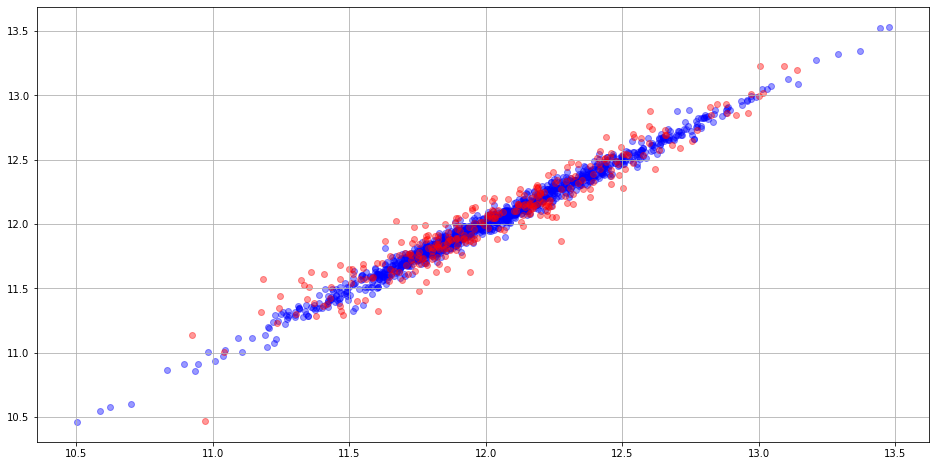

In [30]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_xgb_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_xgb_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

In [32]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# using GPU
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=state,
                           eval_metric='rmse', verbosity=2, tree_method='gpu_hist',
                           sampling_method='gradient_based')

# setting parameters
learningrate = [0.075, 0.1, 0.125]
gamm = [0.0025, 0.005, 0.0075, 0.01]
# maxdepth = [2, 4, 6]
sub_sample = [0.625, 0.65, 0.7, 0.725]
lambd = [0.01, 0.05, 0.1, 0.15]
alph = [0.01, 0.05, 0.1, 0.15]

gparam_xgb_fs = {'eta': learningrate,
                 'gamma': gamm,
#               'max_depth': maxdepth,
                 'subsample': sub_sample,
                 'lambda': lambd,
                 'alpha': alph}

# setting parameters
gs_xgb_fs = ms.GridSearchCV(xgb_reg, gparam_xgb_fs, cv=n_folds, refit=True, n_jobs=-1,
                            scoring='neg_root_mean_squared_error', return_train_score=True,
                            verbose=3)

%time gs_xgb_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_xgb_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_xgb_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_xgb_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_xgb_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_res_df = pd.DataFrame(xgb_list_results).T
xgb_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_res_df = pd.concat([xgb_res_df, best_par_df], axis=1, sort=False)

xgb_res_df

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Wall time: 34min 48s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,alpha,eta,gamma,lambda,subsample
0,0.98291,0.924658,0.051815,0.112998,-0.061183,0.05,0.075,0.0075,0.05,0.65


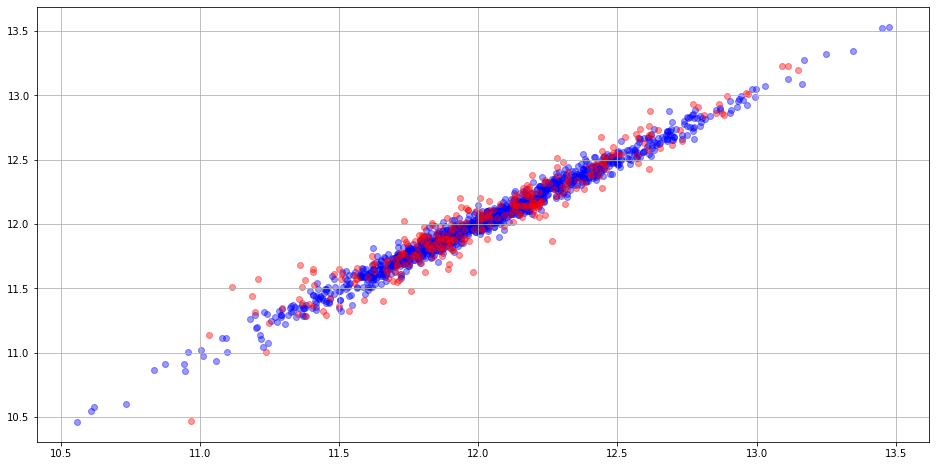

In [33]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_xgb_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_xgb_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

In [34]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []

# using GPU
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=state,
                           eval_metric='rmse', verbosity=2, tree_method='gpu_hist',
                           sampling_method='gradient_based')

# setting parameters
learningrate = [0.05, 0.06, 0.07, 0.075, 0.08]
gamm = [0.006, 0.007, 0.0075, 0.008]
# maxdepth = [2, 4, 6]
sub_sample = [0.63, 0.64, 0.65, 0.66, 0.67]
lambd = [0.04, 0.05, 0.06]
alph = [0.04, 0.05, 0.06]

gparam_xgb_fs = {'eta': learningrate,
                 'gamma': gamm,
#               'max_depth': maxdepth,
                 'subsample': sub_sample,
                 'lambda': lambd,
                 'alpha': alph}

# setting parameters
gs_xgb_fs = ms.GridSearchCV(xgb_reg, gparam_xgb_fs, cv=n_folds, refit=True, n_jobs=-1,
                            scoring='neg_root_mean_squared_error', return_train_score=True,
                            verbose=3)

%time gs_xgb_fs.fit(xtrain_fs, ytrain_fs)

# setting up dataframe for results
train_scores.append(gs_xgb_fs.best_estimator_.score(xtrain_fs, ytrain_fs))
test_scores.append(gs_xgb_fs.best_estimator_.score(xtest_fs, ytest_fs))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_fs, ytrain_fs, xtrain_fs))
test_rmse.append(rmse(gs_xgb_fs, ytest_fs, xtest_fs))

# add the best parameters to the df
best_par_list.append(gs_xgb_fs.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_res_df = pd.DataFrame(xgb_list_results).T
xgb_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_res_df = pd.concat([xgb_res_df, best_par_df], axis=1, sort=False)

xgb_res_df

Fitting 5 folds for each of 900 candidates, totalling 4500 fits
Wall time: 40min 33s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,alpha,eta,gamma,lambda,subsample
0,0.986007,0.926535,0.046885,0.111581,-0.064696,0.04,0.08,0.006,0.04,0.67


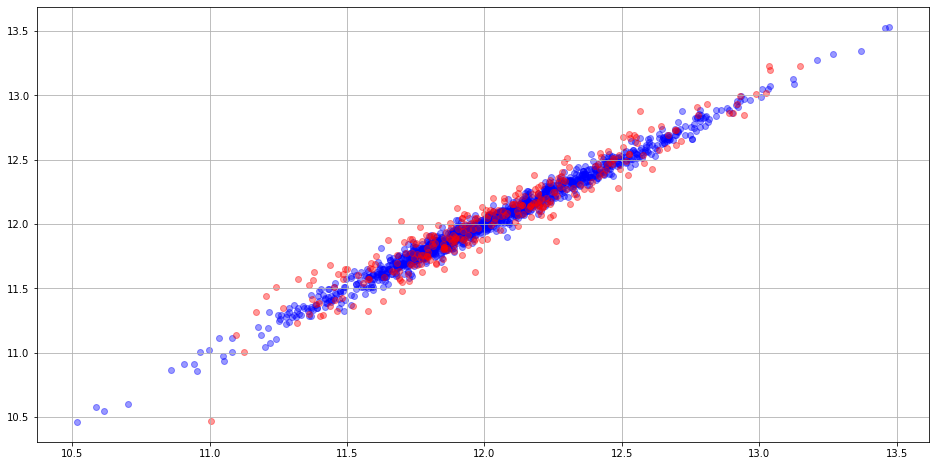

In [35]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_xgb_fs.best_estimator_.predict(xtrain_fs), ytrain_fs, color='blue', alpha=0.4)
plt.scatter(gs_xgb_fs.best_estimator_.predict(xtest_fs), ytest_fs, color='red', alpha=0.4)
plt.grid(which='both')

# Experimental

In [40]:
xgb_experimental = copy.deepcopy(xgb_df)

# Adding Seasons
experiment = copy.deepcopy(combo)

to_num = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6,
          'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}

experiment['MoSold'] = experiment['MoSold'].map(to_num)

experiment['SeasonSold'] = 'Spring'

experiment.loc[(experiment['MoSold']==6) |
               (experiment['MoSold']==7) | 
               (experiment['MoSold']==8), 'SeasonSold'] = 'Summer'

experiment.loc[(experiment['MoSold']==9) |
               (experiment['MoSold']==10) |
               (experiment['MoSold']==11), 'SeasonSold'] = 'Fall'

experiment.loc[(experiment['MoSold']==12) | 
               (experiment['MoSold']==1) | 
               (experiment['MoSold']==2), 'SeasonSold'] = 'Winter'

# changing combo now so that I could use month number in experiment df
# https://stackoverflow.com/questions/37625334/python-pandas-convert-month-int-to-month-name
import calendar

# Adding Sold Date

experiment[['MoSold', 'YrSold']] = experiment[['MoSold', 'YrSold']].astype(int)

experiment['DateSold'] = pd.to_datetime(experiment.YrSold.astype(str) +\
                                        '-' + experiment.MoSold.astype(str))

experiment['MoSold'] = experiment ['MoSold'].apply(lambda x: calendar.month_abbr[x])

# adding WSJ Prime Rate
# https://en.wikipedia.org/wiki/Wall_Street_Journal_prime_rate
experiment['WSJPrime'] = 0
experiment.loc[experiment['DateSold']>='2005-12-01 00:00:00', 'WSJPrime'] = 7.25
experiment.loc[experiment['DateSold']>='2006-02-01 00:00:00', 'WSJPrime'] = 7.50
experiment.loc[experiment['DateSold']>='2006-04-01 00:00:00', 'WSJPrime'] = 7.75
experiment.loc[experiment['DateSold']>='2006-05-01 00:00:00', 'WSJPrime'] = 8.00
experiment.loc[experiment['DateSold']>='2006-07-01 00:00:00', 'WSJPrime'] = 8.25
experiment.loc[experiment['DateSold']>='2007-09-01 00:00:00', 'WSJPrime'] = 7.75
experiment.loc[experiment['DateSold']>='2007-11-01 00:00:00', 'WSJPrime'] = 7.50
experiment.loc[experiment['DateSold']>='2007-12-01 00:00:00', 'WSJPrime'] = 7.25
experiment.loc[experiment['DateSold']>='2008-01-01 00:00:00', 'WSJPrime'] = 6.50
experiment.loc[experiment['DateSold']>='2008-02-01 00:00:00', 'WSJPrime'] = 6.00
experiment.loc[experiment['DateSold']>='2008-03-01 00:00:00', 'WSJPrime'] = 5.25
experiment.loc[experiment['DateSold']>='2008-05-01 00:00:00', 'WSJPrime'] = 5.00
experiment.loc[experiment['DateSold']>='2008-10-01 00:00:00', 'WSJPrime'] = 4.50
experiment.loc[experiment['DateSold']>='2008-11-01 00:00:00', 'WSJPrime'] = 4.00
experiment.loc[experiment['DateSold']>='2008-12-01 00:00:00', 'WSJPrime'] = 3.25
experiment.loc[experiment['DateSold']>='2015-12-01 00:00:00', 'WSJPrime'] = 3.50

# for experimental dataset
to_paste = experiment[['DateSold', 'WSJPrime', 'MoSold', 'YrSold']]

xgb_df = xgb_df.drop(['MoSold'], axis=1)

new_cols = list(xgb_df.columns) + list(to_paste.columns)

xgb_experiment = pd.DataFrame(np.concatenate((xgb_df.loc[hp_index], to_paste.loc[hp_index]),
                                             axis=1), columns = new_cols)

# converting columns containing numbers to numeric type
for col in xgb_experiment.columns: 
    xgb_experiment[col] = xgb_experiment[col].astype('float', errors='ignore')

# dummify and scale the dataset
hp_experimental = copy.deepcopy(dum_scale(xgb_experiment))
hp_experimental_to_use = copy.deepcopy(hp_experimental.loc[hp_index])

hp_experimental_to_use

,Fireplace,TotalPorchSF,TotalLivSF,LotFrontage,LotArea,Street,Alley,Utilities,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolQC,Fence,MiscVal,NbMedianRank,DateSold,WSJPrime,YrSold,MSSubClass_1-1/2 STORY FINISHED ALL AGES,MSSubClass_1-STORY 1945 & OLDER,MSSubClass_1-STORY 1946 & NEWER ALL STYLES,MSSubClass_1-STORY PUD (Planned Unit Development) - 1946 & NEWER,MSSubClass_1-STORY W/FINISHED ATTIC ALL AGES,MSSubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MSSubClass_2-1/2 STORY ALL AGES,MSSubClass_2-STORY 1945 & OLDER,MSSubClass_2-STORY 1946 & NEWER,MSSubClass_2-STORY PUD - 1946 & NEWER,MSSubClass_DUPLEX - ALL STYLES AND AGES,MSSubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MSSubClass_SPLIT FOYER,MSSubClass_SPLIT OR MULTI-LEVEL,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_TwnhsE,BldgType_TwnhsI,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_BrkComm,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CemntBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_WdShing,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep
0,0.0,0.059396,0.333761,0.150685,0.033420,1.0,0.0,1.0,0.666667,0.500,0.949275,0.122500,0.666667,0.50,0.8,0.75,0.25,1.000000,0.322669,0.166667,0.000000,0.06

In [41]:
state = 0

# setting up train and test sets
xtrain_exp, xtest_exp, ytrain_exp, ytest_exp = ms.train_test_split(hp_experimental_to_use,
                                                                   hp_logsp,
                                                                   test_size=0.2,
                                                                   random_state=state)

# Must flatten to fit
ytrain_exp = ytrain_exp.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

In [42]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []


# setting parameters
learningrate = [0.1, 0.3, 0.5, 1]
gamm = [0, 0.1, 1]
sub_sample = [0.1, 0.25, 0.5, 1]
lambd = [0.25, 0.5, 0.75, 1]
alph = [0.25, 0.5, 0.75, 1]

gparam_xgb = {'eta': learningrate,
              'gamma': gamm,
              'subsample': sub_sample,
              'lambda': lambd,
              'alpha': alph}

# setting parameters
gs_xgb_exp = ms.GridSearchCV(xgb_reg, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True,
                             verbose=4)

%time gs_xgb_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_xgb_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_xgb_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_xgb_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_xgb_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_res_df = pd.DataFrame(xgb_list_results).T
xgb_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_res_df = pd.concat([xgb_res_df, best_par_df], axis=1, sort=False)

xgb_res_df

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
Wall time: 25min 52s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,alpha,eta,gamma,lambda,subsample
0,0.980339,0.922775,0.055575,0.114402,-0.058826,0.25,0.1,0,1,0.5


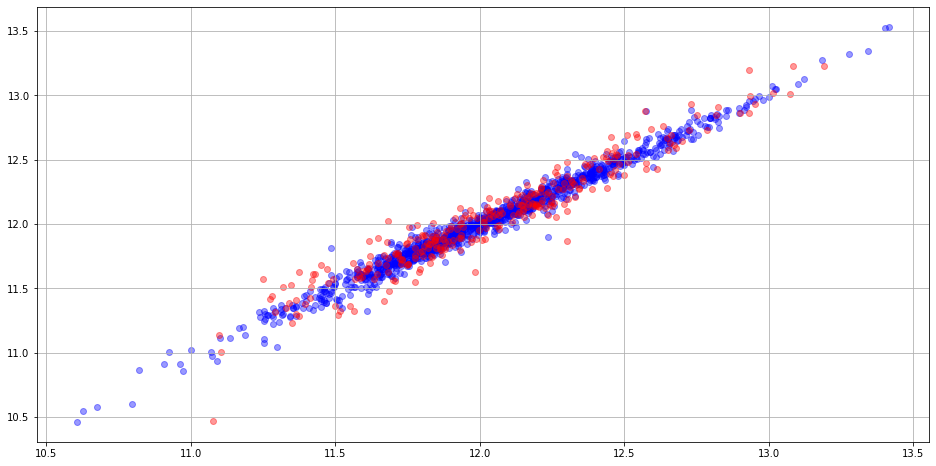

In [43]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_xgb_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_xgb_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

In [44]:
train_scores = []
test_scores = []
train_rmse = []
test_rmse = []
best_par_list = []


# setting parameters
learningrate = [0.05, 0.1, 0.15, 0.2]
gamm = [0, 0.0001, 0.001]
sub_sample = [0.3, 0.4, 0.5, 0.6]
lambd = [0.8, 0.9, 1]
alph = [0.15, 0.2, 0.25, 0.3, 0.4]

gparam_xgb = {'eta': learningrate,
              'gamma': gamm,
              'subsample': sub_sample,
              'lambda': lambd,
              'alpha': alph}

# setting parameters
gs_xgb_exp = ms.GridSearchCV(xgb_reg, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1,
                             scoring='neg_root_mean_squared_error', return_train_score=True,
                             verbose=4)

%time gs_xgb_exp.fit(xtrain_exp, ytrain_exp)

# setting up dataframe for results
train_scores.append(gs_xgb_exp.best_estimator_.score(xtrain_exp, ytrain_exp))
test_scores.append(gs_xgb_exp.best_estimator_.score(xtest_exp, ytest_exp))

# use rmse function from Self_Written_Functions_Sheet_Recover
train_rmse.append(rmse(gs_xgb_exp, ytrain_exp, xtrain_exp))
test_rmse.append(rmse(gs_xgb_exp, ytest_exp, xtest_exp))

# add the best parameters to the df
best_par_list.append(gs_xgb_exp.best_params_)

# find the difference btwn the rmses
diff_rmse = np.subtract(train_rmse, test_rmse)

# create dataframe
xgb_list_results = [train_scores, test_scores, train_rmse, test_rmse, diff_rmse]
xgb_res_df = pd.DataFrame(xgb_list_results).T
xgb_res_df.columns = ['TrainScores', 'TestScores', 'TrainRMSE', 'TestRMSE', 'DiffRMSE']
best_par_df = pd.DataFrame(best_par_list)
xgb_res_df = pd.concat([xgb_res_df, best_par_df], axis=1, sort=False)

xgb_res_df

Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Wall time: 34min 23s


,TrainScores,TestScores,TrainRMSE,TestRMSE,DiffRMSE,alpha,eta,gamma,lambda,subsample
0,0.983658,0.926829,0.050668,0.111358,-0.06069,0.25,0.1,0,0.9,0.6


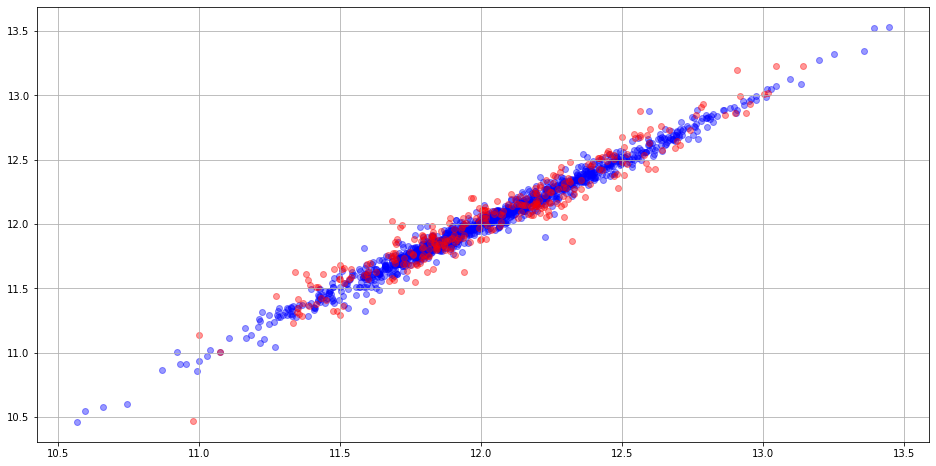

In [45]:
plt.figure(figsize=(16, 8))
plt.scatter(gs_xgb_exp.best_estimator_.predict(xtrain_exp), ytrain_exp, color='blue', alpha=0.4)
plt.scatter(gs_xgb_exp.best_estimator_.predict(xtest_exp), ytest_exp, color='red', alpha=0.4)
plt.grid(which='both')

# BEST PARAM

In [ ]:
# make copies of the original df to edit each individually according to the best scores/feat eng pair
xgb_df = copy.deepcopy(combo_nonedit)

# copy and paste the functions from the dictionary results above
xgb_feat_eng = [nbrhd_rank, totallivsf_add, totalporchsf_add, totalbaths_add, totalbsmtbaths_add,
                drop_nbrhd, drop_bsmtfinsf12, drop_yrsoldremod, drop_baths, drop_bsmtbaths]

for feat in xgb_feat_eng:
    feat(xgb_df)

# dummify and scale the dataset
hp_full_strd = copy.deepcopy(dum_scale(xgb_df))

hp_full_strd_to_use = copy.deepcopy(hp_full_strd.loc[hp_index])

sorted_importance_xgb = sorted(zip(hp_full_strd_to_use.columns,
                                   gs_xgb.best_estimator_.feature_importances_),
                               key=lambda t:t[1], reverse=True)

filtered_sorted_importance_xgb = [x for x in sorted_importance_xgb if x[1]>0]

df_filter_sort_xgb = [x[0] for x in filtered_sorted_importance_xgb]

df_filter_sort_xgb

hp_fullstrd_filtrsrt = hp_full_strd_to_use[df_filter_sort_xgb]
hp_fullstrd_filtrsrt

state = 0

# setting up train and test sets
xtrain, xtest, ytrain, ytest = ms.train_test_split(hp_fullstrd_filtrsrt,
                                                   hp_logsp,
                                                   test_size=0.2,
                                                   random_state=state)

# Must flatten to fit
ytrain = ytrain.values.flatten()

# using standard kfold split
n_folds = ms.KFold(n_splits=5, random_state=state, shuffle=True)

xgb = RandomForestRegressor(random_state=0)

# setting parameters
learningrate = [0.1]
gamm = [0.01]
sub_sample = [0.75]
lambd = [0.25]
alph = [0.25]

gparam_xgb = {'eta': learningrate,
              'gamma': gamm,
              'subsample': sub_sample,
              'lambda': lambd,
              'alpha': alph}

# setting parameters
gs_xgb = ms.GridSearchCV(xgb, gparam_xgb, cv=n_folds, refit=True, n_jobs=-1,
                           scoring='neg_root_mean_squared_error', return_train_score=True)

%time gs_xgb.fit(xtrain, ytrain)